In [1]:
%run dr2-groupten-settings.ipynb

/Users/semyeong/projects/spelunky
/Users/semyeong/projects/Group10/notebooks
Loaded g10_region from cache
Loaded g10_region_phot from cache 3413 rows
Loaded g10_region_ps from cache 3413 rows
Loaded g10_region_dr1 from cache 3428 rows
Loaded g10_region_ravedr5 from cache 3413 rows
Loaded g10_region_tycho2 from cache 3414 rows
Load David & Hillenbrand 2015 table 5 to `dht5`
135118 in 2RXS
CPU times: user 8.36 s, sys: 265 ms, total: 8.62 s
Wall time: 8.76 s


# Candidate member selection

## Simple proper-motion mask

In [16]:
pmmask = dict(center=(-16.1, -3.1), a=7, b=3.5, theta=40)
def ellipse_mask(x, y, center, a, b, theta):
    """Return boolean array masking ellipse"""
    xc, yc = center
    s, c = np.sin(theta), np.cos(theta)
    xn = c*(x-xc) -s*(y-yc)
    yn = s*(x-xc) + c*(y-yc)
    return xn**2/a**2 + yn**2/b**2 < 1
select = ellipse_mask(g10_region.pmra, g10_region.pmdec, pmmask['center'],
                      pmmask['a'], pmmask['b'], pmmask['theta'])
# candi = g10_region.loc[select]
print('number in ellipse mask = {:d}'.format(select.sum()))

number in ellipse mask = 226


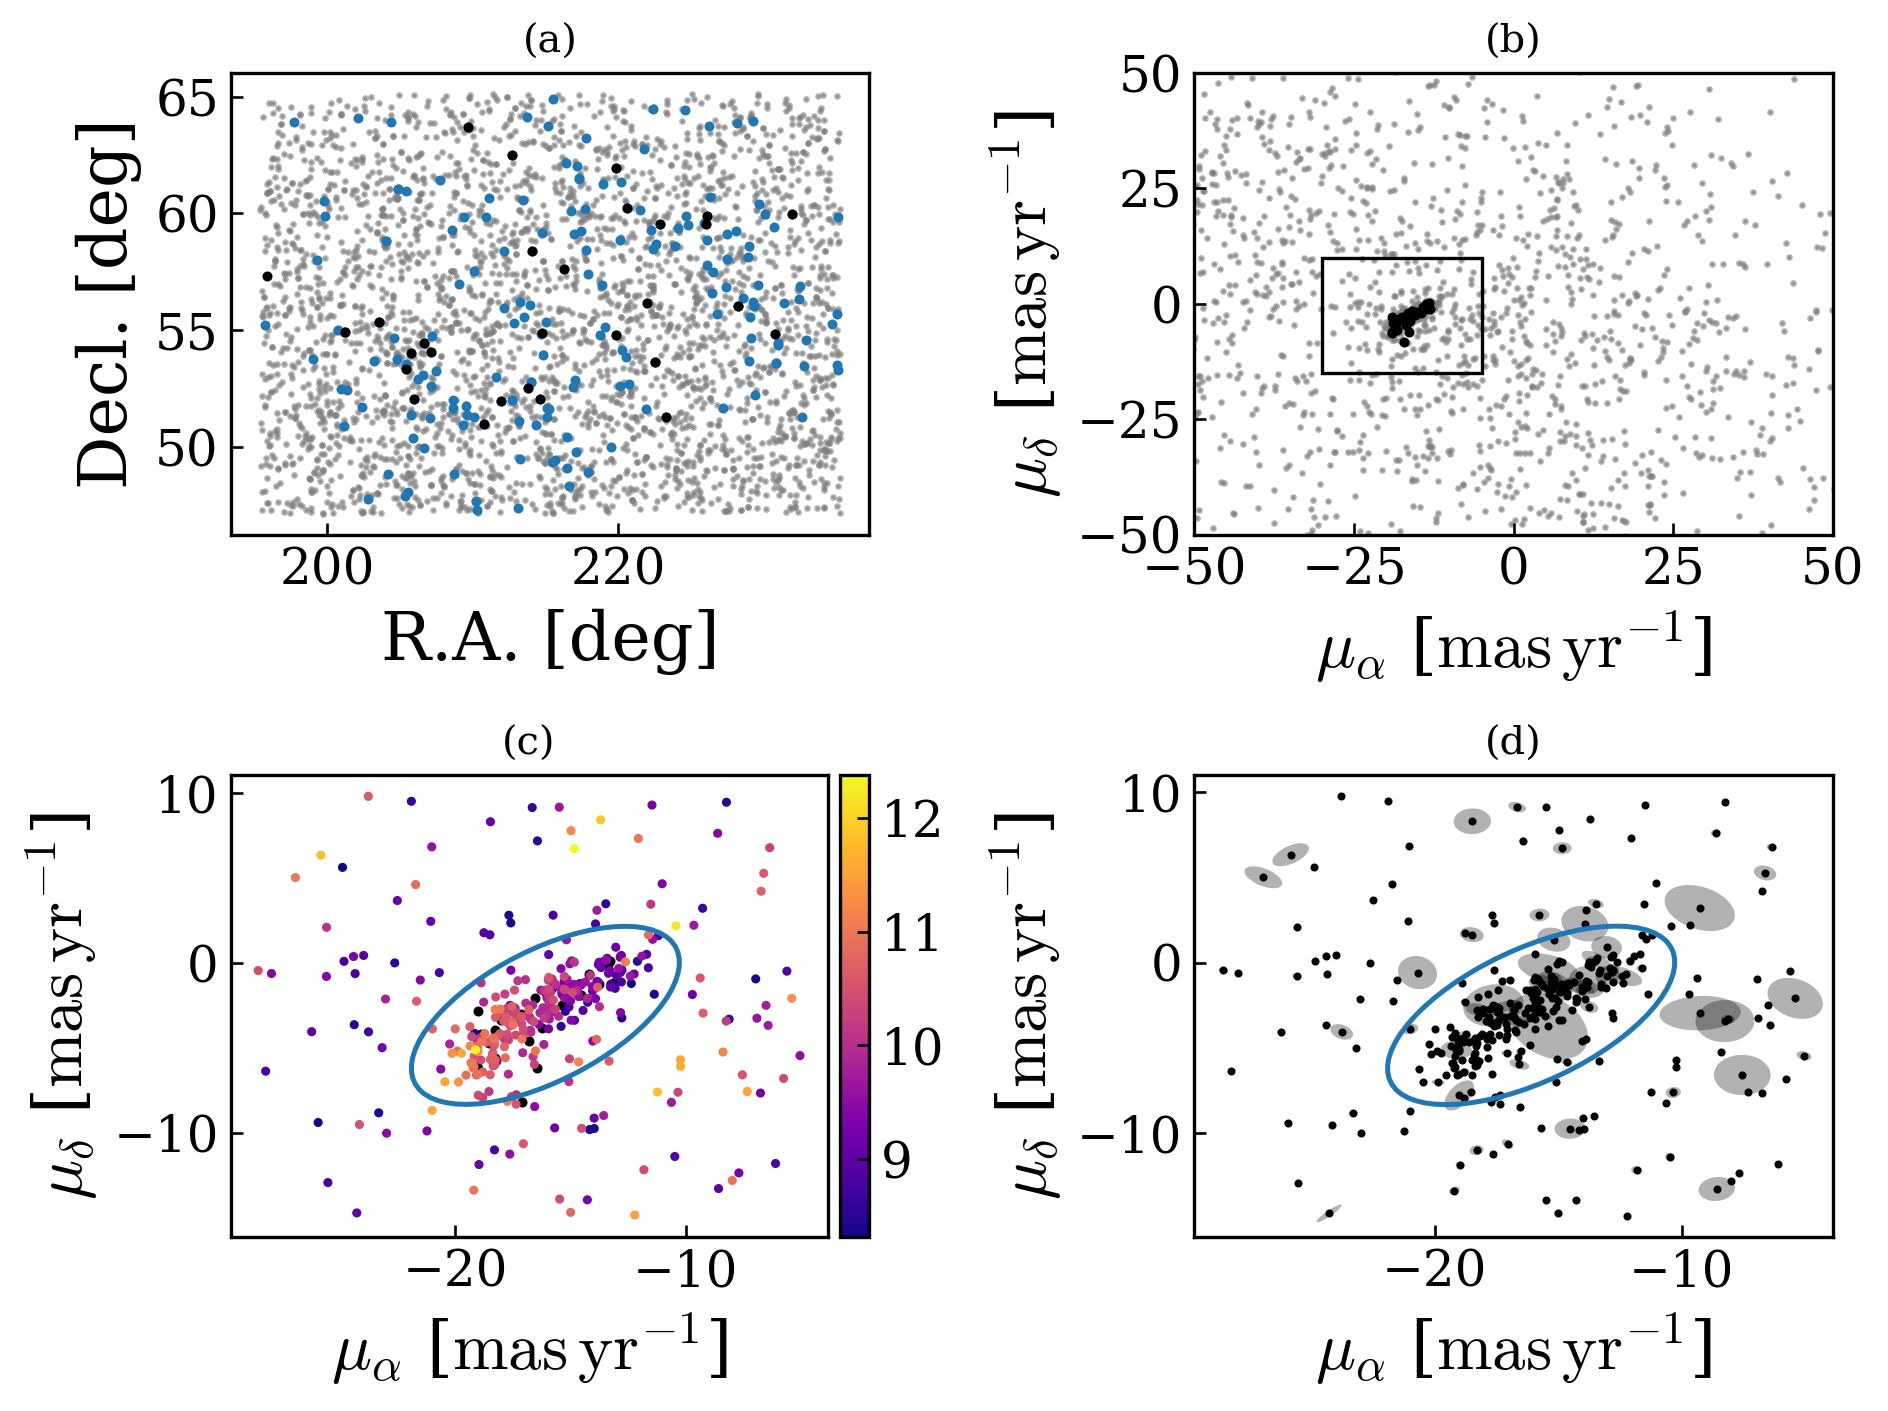

In [48]:
fig, ax = plt.subplots(2, 2, figsize=(8,6))
fig.subplots_adjust(wspace=0.35)
ax = ax.ravel()

ax[1].set_xlim(-50, 50)
ax[1].set_ylim(-50, 50)

g10_region.plot.scatter('ra', 'dec', s=1, ax=ax[0], c='gray', alpha=.6);
g10_region.plot.scatter('pmra', 'pmdec', s=1, ax=ax[1], c='gray', alpha=.6);

candi.plot.scatter('ra', 'dec', s=4, ax=ax[0], c='tab:blue')

g.plot.scatter('ra', 'dec', s=4, ax=ax[0], c='k')
g.plot.scatter('pmra', 'pmdec', s=4, ax=ax[1], c='k')
g.plot.scatter('pmra', 'pmdec', s=4, ax=ax[2], c='k')

zoom = g10_region.query(
    "pmra>-30 and pmra<-5 and pmdec>-15 and pmdec<10 and parallax_over_error>10").copy()
pathcollection = ax[2].scatter(zoom.pmra, zoom.pmdec, c=zoom.parallax, cmap='plasma', s=3)
# add colorbar to the right
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(pathcollection, cax=cax, ticks=[9,10,11,12])

def plot_zoom_rectangle(ax):
    from matplotlib.patches import Rectangle
    rect = Rectangle((-30,-15), 25, 25, facecolor='None', edgecolor='k')
    ax.add_artist(rect)
plot_zoom_rectangle(ax[1])


for _, row in zoom.iterrows():
    plot_cov_ellipse(make_cov(row)[1:,1:], (row.pmra, row.pmdec),
                     facecolor='k', edgecolor='None',
                     alpha=.3, nstd=1,
                     ax=ax[3])
zoom.plot.scatter('pmra','pmdec', s=2, c='k', ax=ax[3])
# Indicate mask ellipse
def plot_ellipse_mask(ax):
    from matplotlib.patches import Ellipse
    mask_ellipse = Ellipse(
        xy=pmmask['center'],
        width=pmmask['a']*2,
        height=pmmask['b']*2,
        angle=pmmask['theta'],
        edgecolor='tab:blue', facecolor='None', lw=1.5)
    ax.add_artist(mask_ellipse)
plot_ellipse_mask(ax[2])
plot_ellipse_mask(ax[3])

def mark_panel(ax, label):
    ax.set_title(label)
mark_panel(ax[0], '(a)')
mark_panel(ax[1], '(b)')
mark_panel(ax[2], '(c)')
mark_panel(ax[3], '(d)')

ax[0].set_xlabel('{ra} [{deg}]'.format(**figsymbols))
ax[0].set_ylabel('{dec} [{deg}]'.format(**figsymbols))
for curax in ax[1:]:
    curax.set_xlabel('{pmra} [{masyr}]'.format(**figsymbols))
    curax.set_ylabel('{pmdec} [{masyr}]'.format(**figsymbols))

fig.tight_layout()
fig.savefig("../paper/figures/g10_sky_pm.pdf")

Remove outliers with RVs.

In [19]:
print(len(candi))
print('has rv: {:d}'.format(candi.radial_velocity.notnull().sum()))

194
has rv: 31


In [ ]:
from astropy.stats import sigma_clip

candi_has6d = candi.pipe(add_xv, coords.Galactic).dropna(subset=['vx'])
vx,vy,vz = candi_has6d[['vx','vy','vz']].values.T

ix = np.where(sigma_clip(vx).mask)[0]
iy = np.where(sigma_clip(vy).mask)[0]
iz = np.where(sigma_clip(vz).mask)[0]

idrop = np.array(list(set(np.concatenate((ix,iy,iz)))))

index_drop = candi_has6d.index[idrop]
print('drop outliers:', index_drop)
candi = candi.drop(index_drop)

In [8]:
candi = candi.pipe(add_xv, coords.Galactic)

## Mixture model in velocities

In [2]:
g10_region = add_xv(g10_region, coords.Galactic)
vra, vdec = g10_region.pmra/g10_region.parallax*4.74, g10_region.pmdec/g10_region.parallax*4.74
g10_region = g10_region.assign(vra=vra, vdec=vdec)

g = g.assign(vra=g.pmra/g.parallax*4.74, vdec=g.pmdec/g.parallax*4.74)

In [3]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

gmm = GaussianMixture(2, covariance_type='full',
                      means_init=[(-7.5,-3), (-5,0)],
                      weights_init=[.7, .3],
                      precisions_init=np.vstack([ (np.eye(2)*1/(1**2))[None,:,:], (np.eye(2)*1/(100.**2))[None,:,:]]));

box = (vra>-15) & (vra<0) & (vdec>-10) & (vdec<10)
X = np.vstack((vra[None,box], vdec[None,box])).T
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=array([[-7.5, -3. ],
       [-5. ,  0. ]]),
        n_components=2, n_init=1,
        precisions_init=array([[[1.e+00, 0.e+00],
        [0.e+00, 1.e+00]],

       [[1.e-04, 0.e+00],
        [0.e+00, 1.e-04]]]),
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False,
        weights_init=array([0.7, 0.3]))

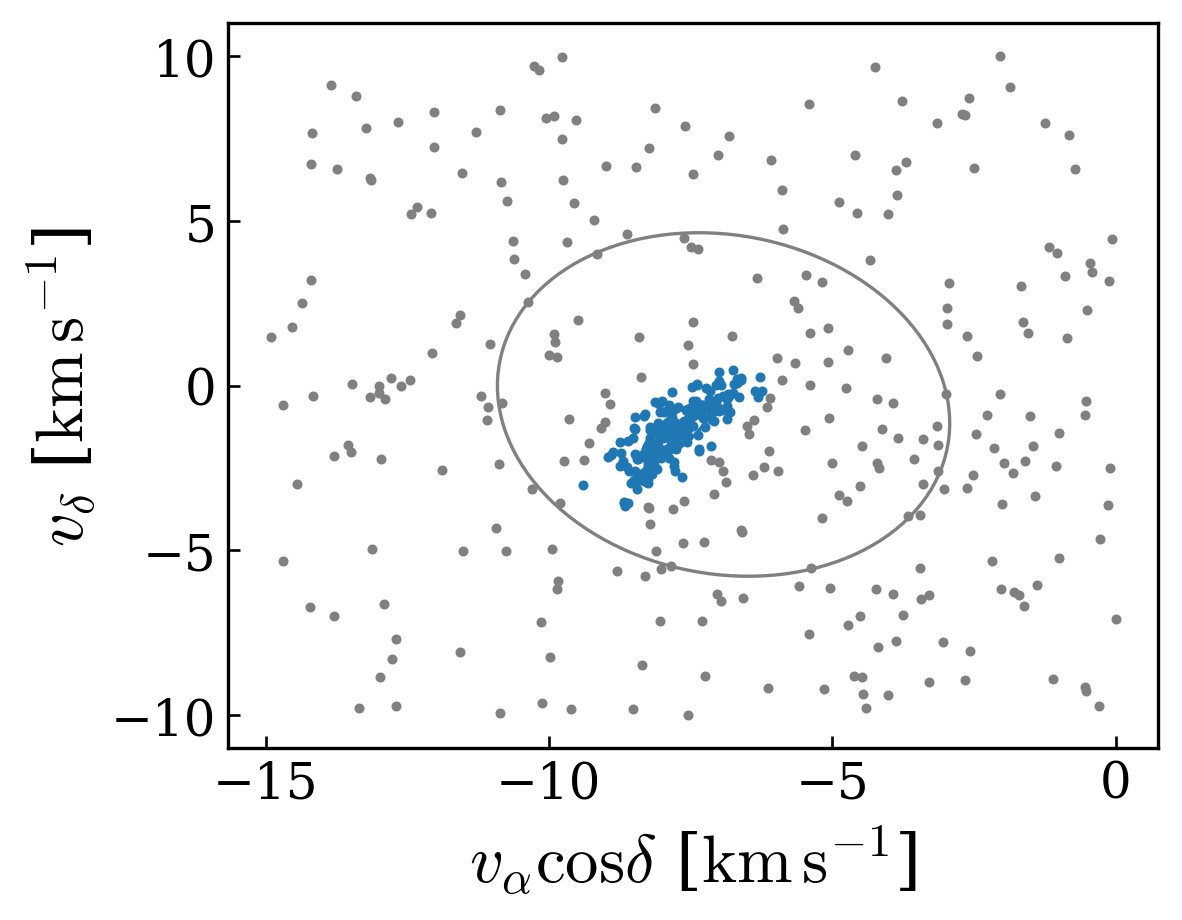

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
colorlist = ['tab:blue', 'gray']
for i, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
    color = colorlist[i]
    Xi = X[gmm.predict(X)==i]
    ax.scatter(*Xi.T, c=color, s=4)
    plot_cov_ellipse(covar, mean, nstd=1, ax=ax, facecolor='None', edgecolor=color, zorder=15)
ax.set_xlabel(r'$v_\alpha\cos\delta$ [$\mathrm{km}\,\mathrm{s}^{-1}$]')
ax.set_ylabel('$v_\delta$ [$\mathrm{km}\,\mathrm{s}^{-1}$]')

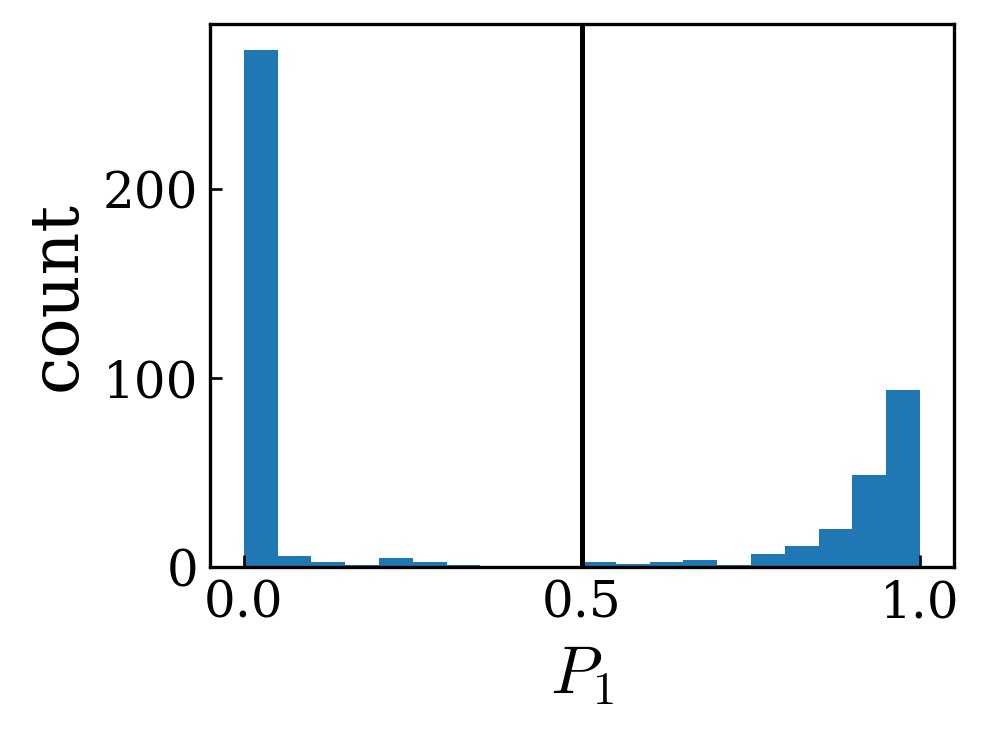

In [5]:
plt.figure(figsize=(4,3))
plt.hist(gmm.predict_proba(X)[:,0], np.linspace(0,1,21));
plt.axvline(0.5, c='k')
plt.xlabel('$P_1$')
plt.ylabel('count')

In [9]:
mem = gmm.predict(X) == 0
print('total number of candidate members = ', mem.sum())

candi = g10_region.loc[box].iloc[mem]
candi.assign(prob0=gmm.predict_proba(X)[mem,0])
# add boolean column 'candi' to g10_region
candi_col = np.zeros(len(g10_region)).astype(bool)
candi_col[candi.index] = True
g10_region = g10_region.assign(candi=candi_col)

total number of candidate members =  194


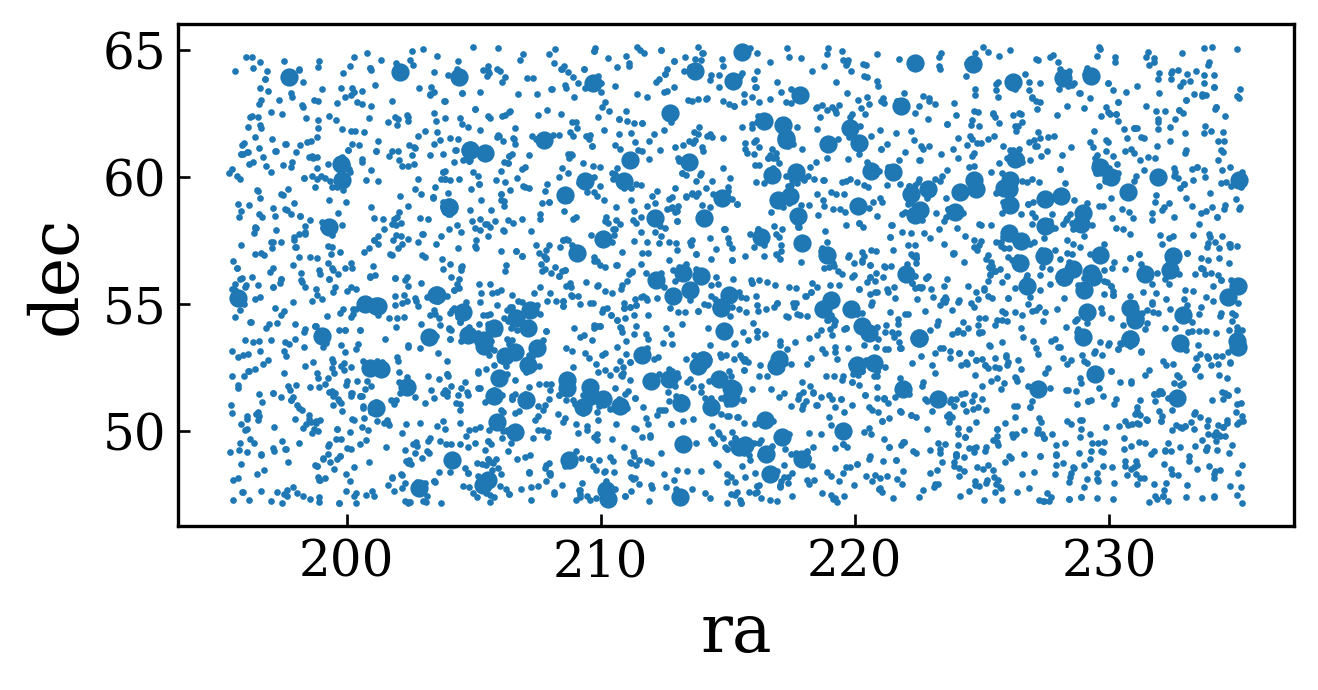

In [18]:
ax = plt.axes(aspect='equal')
g10_region.plot.scatter('ra','dec',s=1,ax=ax)
candi.plot.scatter('ra','dec',ax=ax)

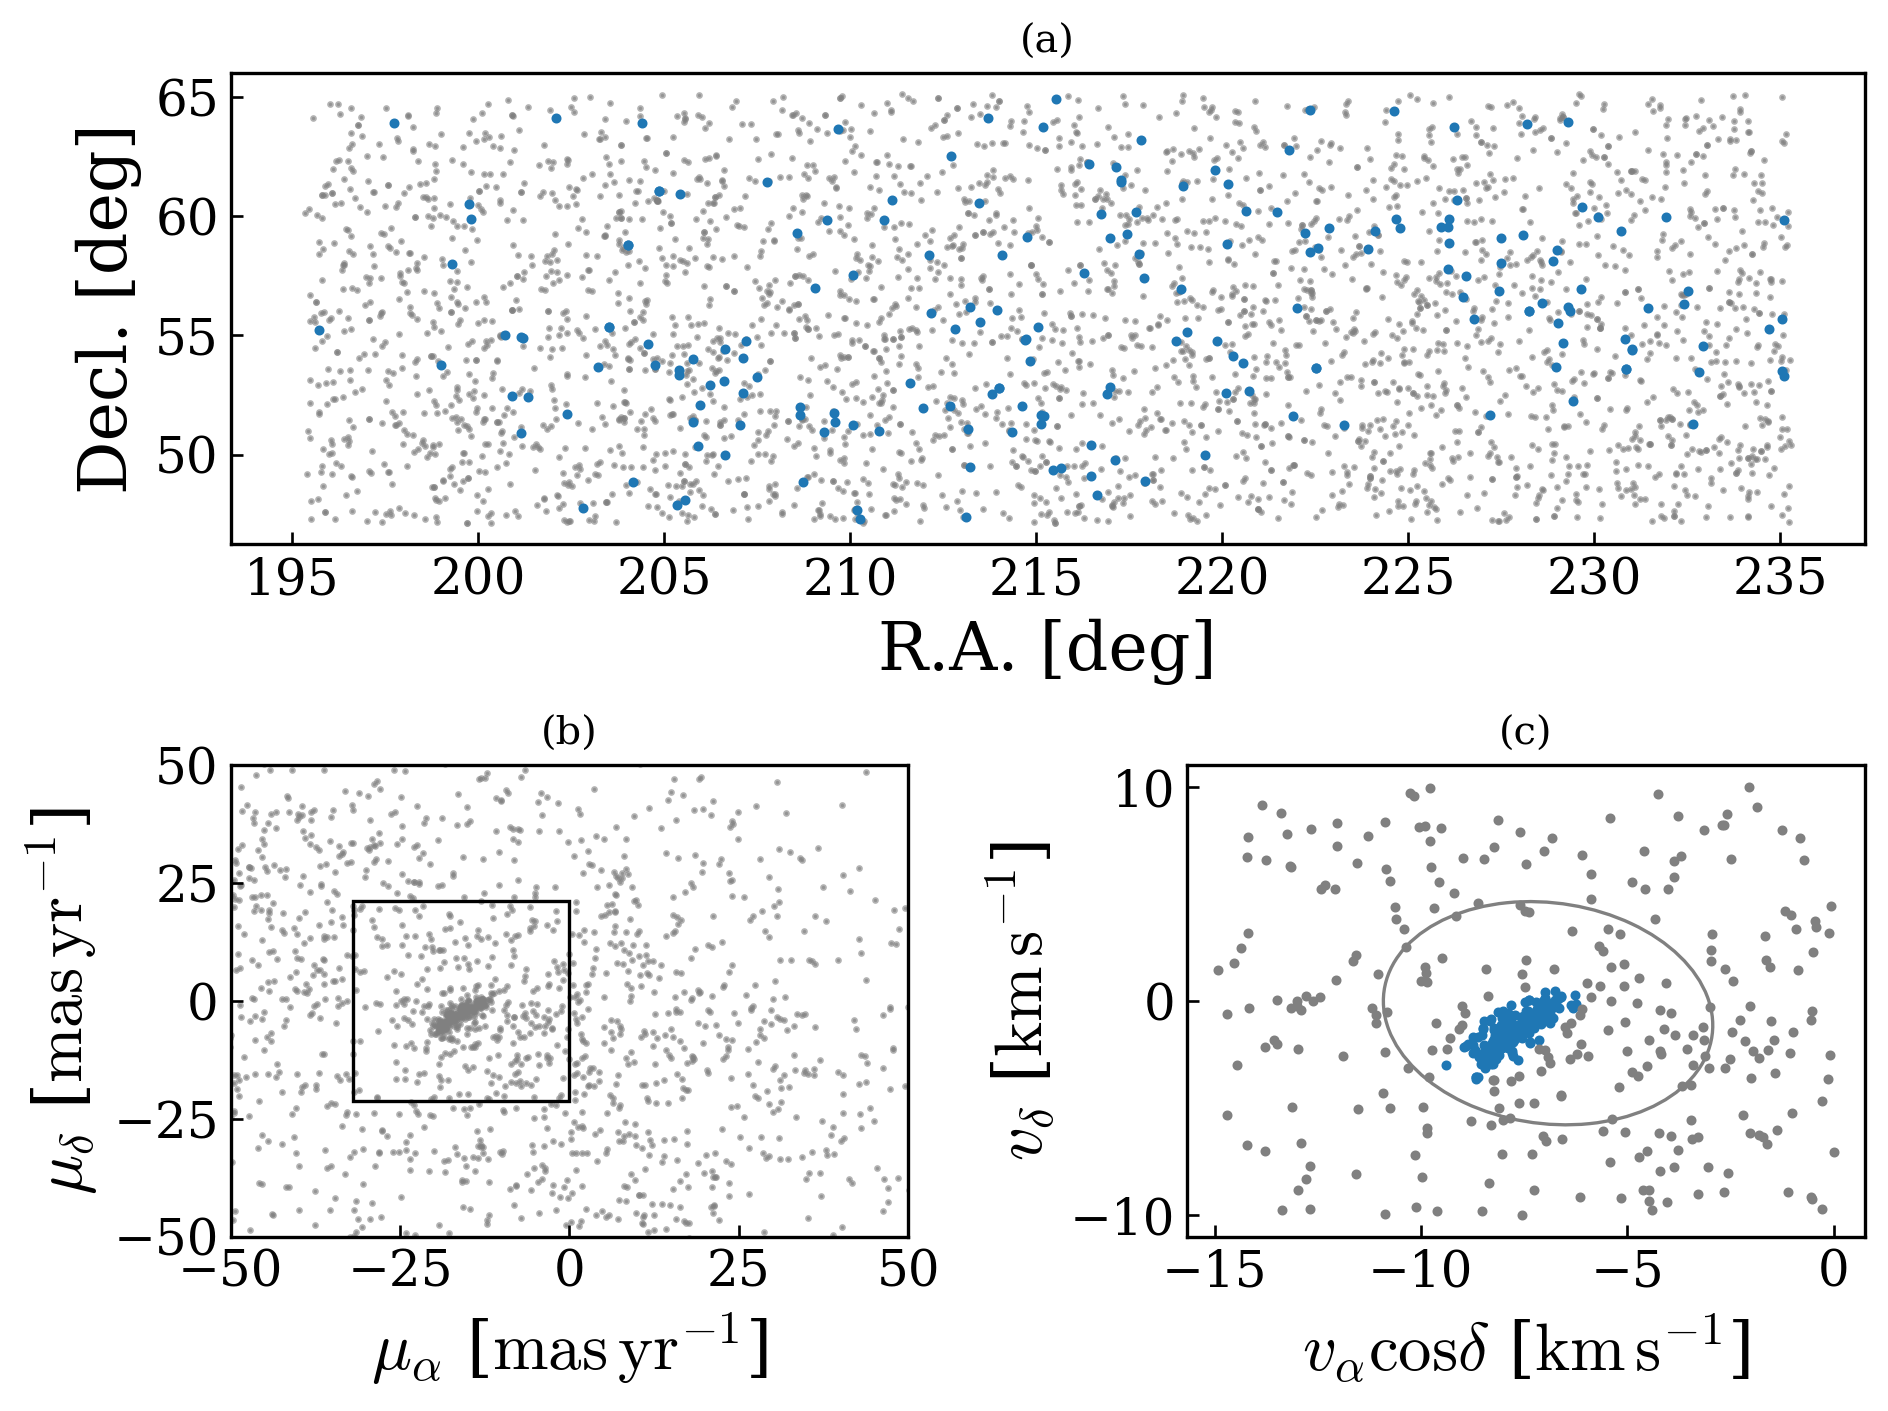

In [36]:
fig = plt.figure(figsize=(8,6))
fig.subplots_adjust(wspace=0.35, hspace=0.4)

ax_sky = plt.subplot2grid((2, 2), (0, 0), colspan=2)
g10_region.plot.scatter('ra', 'dec', s=1, ax=ax_sky, c='gray', alpha=.6);
candi.plot.scatter('ra', 'dec', s=4, ax=ax_sky, c='tab:blue')
ax_sky.set_xlabel('{ra} [{deg}]'.format(**figsymbols))
ax_sky.set_ylabel('{dec} [{deg}]'.format(**figsymbols))

ax_pm = plt.subplot2grid((2, 2), (1, 0))
g10_region.plot.scatter('pmra', 'pmdec', s=1, ax=ax_pm, c='gray', alpha=.6);
def plot_zoom_rectangle(ax):
    median_parallax = candi.parallax.median()
    from matplotlib.patches import Rectangle
    rect = Rectangle(
        (-15*median_parallax/4.74, -10*median_parallax/4.74),
        15*median_parallax/4.74, 20*median_parallax/4.74, facecolor='None', edgecolor='k')
    ax.add_artist(rect)
plot_zoom_rectangle(ax_pm)
ax_pm.set_xlim(-50, 50)
ax_pm.set_ylim(-50, 50)
ax_pm.set_xlabel('{pmra} [{masyr}]'.format(**figsymbols))
ax_pm.set_ylabel('{pmdec} [{masyr}]'.format(**figsymbols))

ax_v = plt.subplot2grid((2, 2), (1, 1))
colorlist = ['tab:blue', 'gray']
for i, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
    color = colorlist[i]
    Xi = X[gmm.predict(X)==i]
    ax_v.scatter(*Xi.T, c=color, s=4)
    plot_cov_ellipse(covar, mean, nstd=1, ax=ax_v, facecolor='None', edgecolor=color, zorder=15)
ax_v.set_xlabel(r'$v_\alpha\cos\delta$ [$\mathrm{km}\,\mathrm{s}^{-1}$]')
ax_v.set_ylabel('$v_\delta$ [$\mathrm{km}\,\mathrm{s}^{-1}$]')

def mark_panel(ax, label):
    ax.set_title(label)
mark_panel(ax_sky, '(a)')
mark_panel(ax_pm, '(b)')
mark_panel(ax_v, '(c)')

fig.tight_layout()
fig.savefig("../paper/figures/g10_sky_pm.pdf")

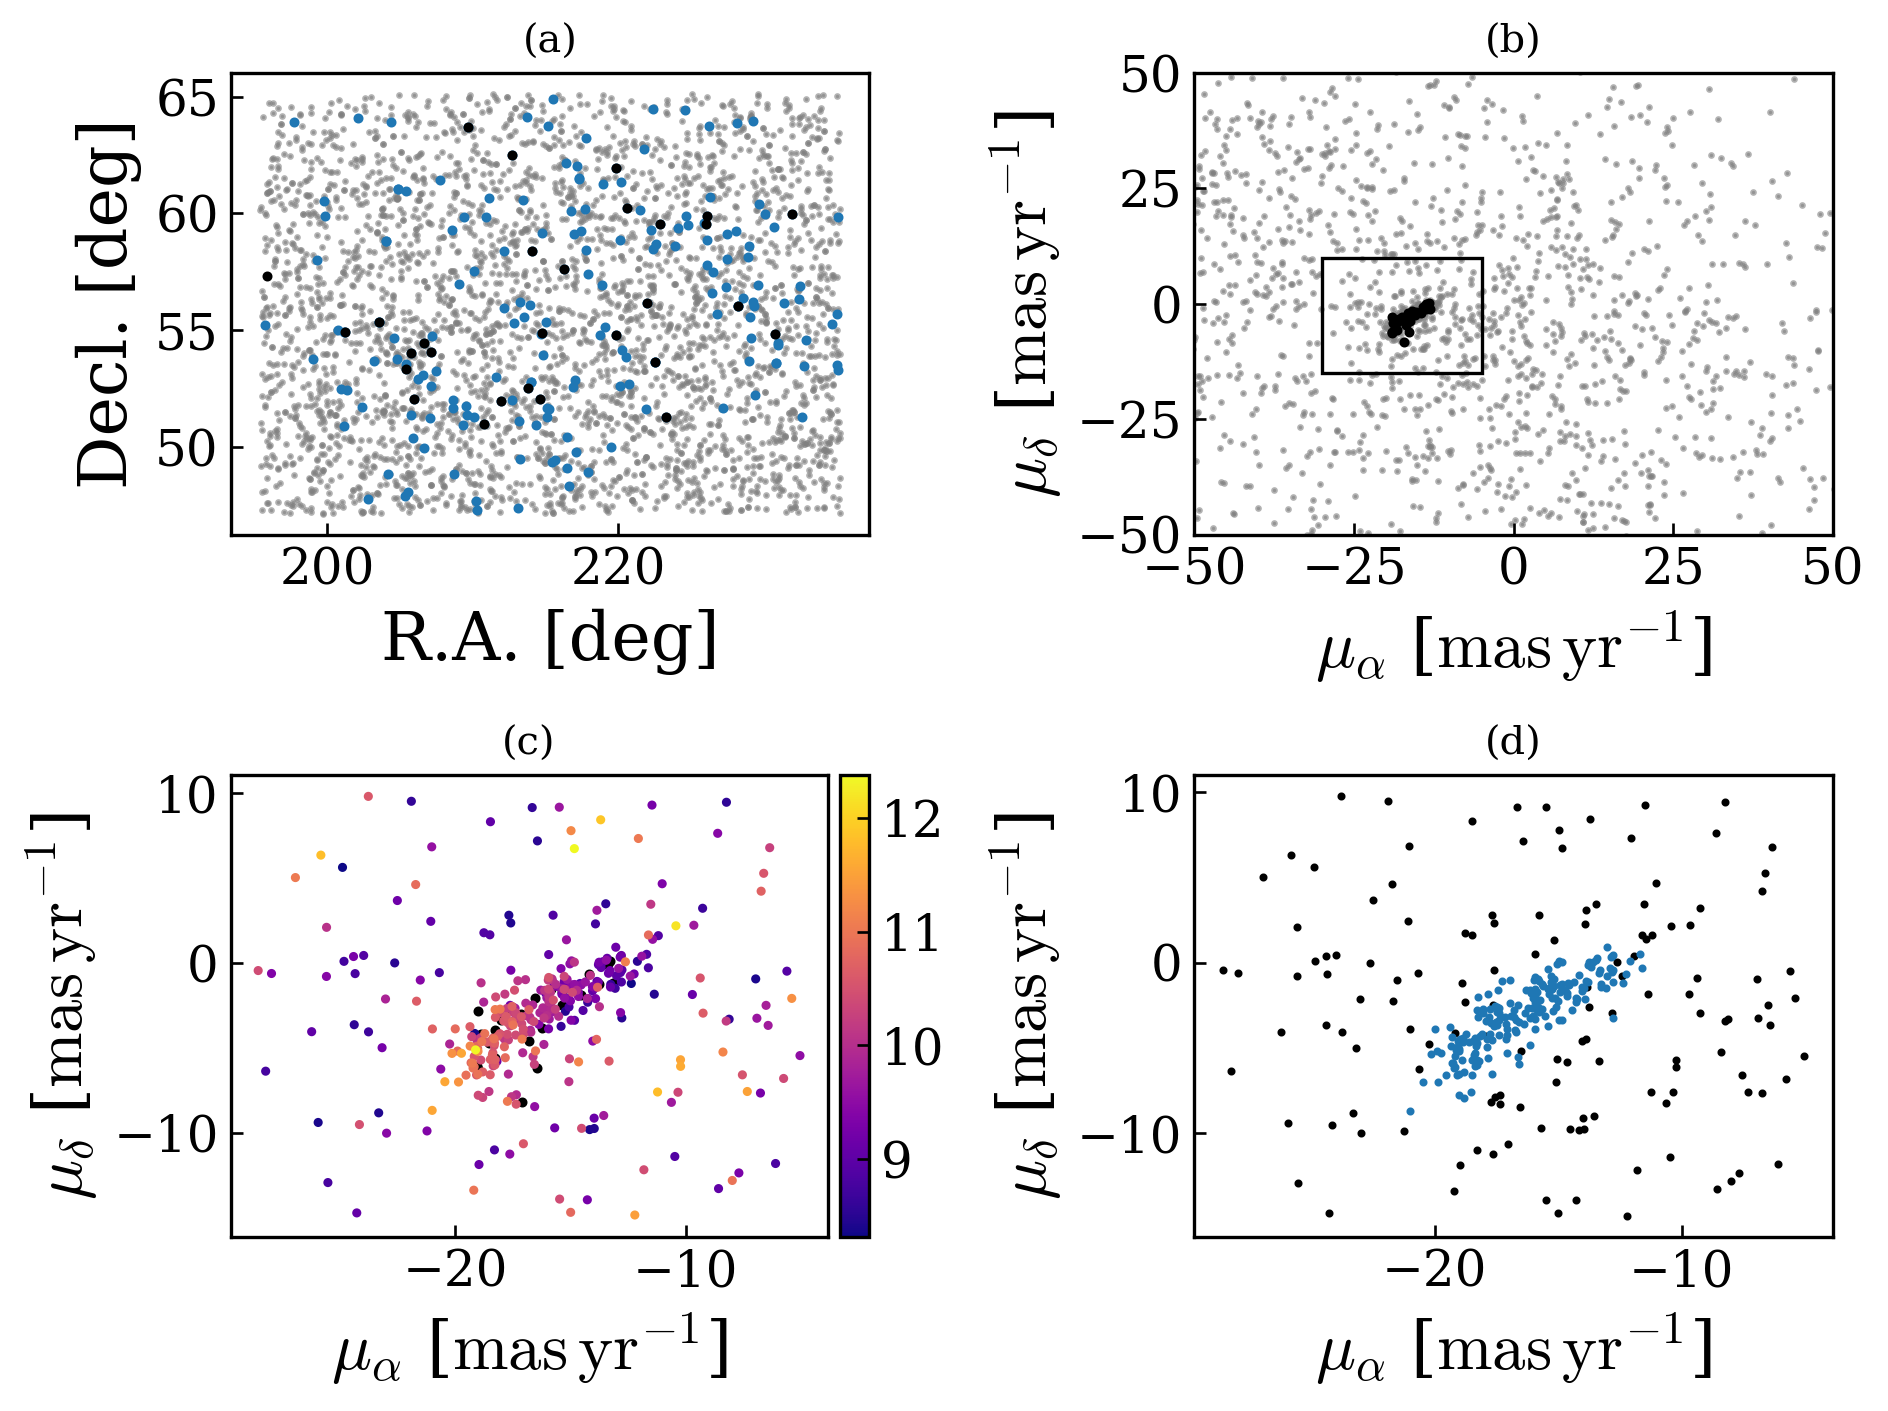

In [72]:
fig, ax = plt.subplots(2, 2, figsize=(8,6))
fig.subplots_adjust(wspace=0.35)

ax = ax.ravel()
ax[1].set_xlim(-50, 50)
ax[1].set_ylim(-50, 50)

g10_region.plot.scatter('ra', 'dec', s=1, ax=ax[0], c='gray', alpha=.6);
g10_region.plot.scatter('pmra', 'pmdec', s=1, ax=ax[1], c='gray', alpha=.6);

candi.plot.scatter('ra', 'dec', s=4, ax=ax[0], c='tab:blue')

g.plot.scatter('ra', 'dec', s=4, ax=ax[0], c='k')
g.plot.scatter('pmra', 'pmdec', s=4, ax=ax[1], c='k')
g.plot.scatter('pmra', 'pmdec', s=4, ax=ax[2], c='k')

zoom = g10_region.query(
    "pmra>-30 and pmra<-5 and pmdec>-15 and pmdec<10 and parallax_over_error>10").copy()
pathcollection = ax[2].scatter(zoom.pmra, zoom.pmdec, c=zoom.parallax, cmap='plasma', s=3)
# add colorbar to the right
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(pathcollection, cax=cax, ticks=[9,10,11,12])

# check two famous members
# zoom.loc[zoom.designation==designation_81Uma].plot.scatter('pmra','pmdec',s=16,ax=ax[2])
# zoom.loc[zoom.designation==designation_84Uma].plot.scatter('pmra','pmdec',s=16,ax=ax[2])


def plot_zoom_rectangle(ax):
    from matplotlib.patches import Rectangle
    rect = Rectangle((-30,-15), 25, 25, facecolor='None', edgecolor='k')
    ax.add_artist(rect)
plot_zoom_rectangle(ax[1])


# for _, row in zoom.iterrows():
#     c = 'tab:blue' if row.candi else 'k'
#     plot_cov_ellipse(make_cov(row)[1:,1:], (row.pmra, row.pmdec),
#                      facecolor=c, edgecolor='None',
#                      alpha=.3, nstd=1,
#                      ax=ax[3])
for label, grp in zoom.groupby('candi'):
    c = 'tab:blue' if label else 'k'
    grp.plot.scatter('pmra','pmdec', s=2, c=c, ax=ax[3])


def mark_panel(ax, label):
    ax.set_title(label)
mark_panel(ax[0], '(a)')
mark_panel(ax[1], '(b)')
mark_panel(ax[2], '(c)')
mark_panel(ax[3], '(d)')

ax[0].set_xlabel('{ra} [{deg}]'.format(**figsymbols))
ax[0].set_ylabel('{dec} [{deg}]'.format(**figsymbols))
for curax in ax[1:]:
    curax.set_xlabel('{pmra} [{masyr}]'.format(**figsymbols))
    curax.set_ylabel('{pmdec} [{masyr}]'.format(**figsymbols))


# colorlist = ['tab:blue', 'gray']
# for i, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
#     color = colorlist[i]
#     Xi = X[gmm.predict(X)==i]
#     ax.scatter(*Xi.T, c=color, s=4)
#     plot_cov_ellipse(covar, mean, nstd=1, ax=ax, facecolor='None', edgecolor=color, zorder=15)
# ax.set_xlabel(r'$v_\alpha\cos\delta$ [$\mathrm{km}\,\mathrm{s}^{-1}$]')
# ax.set_ylabel('$v_\delta$ [$\mathrm{km}\,\mathrm{s}^{-1}$]')
    
fig.tight_layout()
fig.savefig("../paper/figures/g10_sky_pm.pdf")

In [26]:
candi.dropna(subset=['vx'])[['x','y','z','vx','vy','vz']].describe()

,x,y,z,vx,vy,vz
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,-8.160936,56.685937,81.647420,-3.588778,-9.018281,-1.443073
std,6.170599,9.846556,4.653874,0.601620,0.898478,1.233510
min,-20.468865,38.275146,71.401982,-4.828197,-10.810618,-4.061249
25%,-12.477154,48.923856,80.201458,-3.891235,-9.503935,-2.277745
50%,-8.931964,57.491110,82.383553,-3.647418,-9.064526,-1.587946
75%,-4.044580,63.624013,83.928004,-3.205023,-8.555698,-0.846659
max,4.924016,73.902932,92.278426,-2.395071,-6.981494,2.027734


In [38]:
%store candi

Stored 'candi' (DataFrame)
